# Notebook to develop the model for the project

# List of ideas to improve the network

0. ## start with easier polynomials
5. ## apply crossvalidation to the training loop
6. ## List all hyperparameters of the network (affecting net performance)
    >### Learning rate, number of epochs, batch size, Dropout rate
    >### Loss function, Optimizer, Network architecture
    >### CNN layers NofElement, arrangment, and parameters
    >### FC layers NofElement, arrangment, and parameters
7. ## Build a much larger much richer dataset with transforms to more than 10^5 sample, that is statistically sound (no extreme bias, etc...)
8. ## Apply planned data augmentation transforms


In [9]:
# All our imports
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import randint
import PIL
import os

#for all the plots to be inline
%matplotlib inline 


In [10]:
'''reads data from the plot folder'''
class custom_dataset(torch.utils.data.Dataset):

    def __init__(self, csv_path, images_folder, transform):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.values[index][0]
        labels = np.array([1, 1, 1, 1, 1, 1, 1, 1])
        for x in range(0, 8):
            labels[x] = self.df.values[index][x+1]
        image = PIL.Image.open(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, labels


In [11]:
'''Selecting Device to run on'''
# Select device to train on
device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)
print(device)
# device = 'cpu' # force device to be cpu

cuda:0


In [12]:
'''Data Set manipulation'''
transform = transforms.Compose([
    # 3 grey channels because of DenseNet
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor()
])

root = "D:\\Downloads\\plotData"
trainDataset = custom_dataset(
    root + "\\labels\\trainPlots.csv",
    root + "\\trainPlots", transform
)

testDataset = custom_dataset(
    root + "\\labels\\testPlots.csv",
    root + "\\testPlots", transform
)

In [13]:
'''Setting up the loaders for the data'''

BATCHSIZE = 128
train_set = torch.utils.data.DataLoader(
    trainDataset, 
    shuffle=True, 
    batch_size=BATCHSIZE
)
test_set = torch.utils.data.DataLoader(
    testDataset, 
    shuffle=False, 
    batch_size=BATCHSIZE
)
print(f'training set size = {len(train_set)}')
print(f'testing set size = {len(test_set)}')

training set size = 6830
testing set size = 1171


torch.Size([128, 3, 96, 96]) torch.Size([128, 8])
Train Set 0
Image: tensor([[[0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         ...,
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745]],

        [[0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         ...,
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.8235],
         [0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745]],

        [[0.6745, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.6745],
         [0.8235, 1.0000, 1.0000,  ..., 1.0000, 1.0000

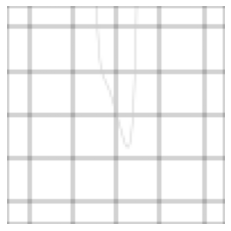

In [14]:
'''Checking the training set'''
#one way to see batch size
train_batch = next(iter(train_set))
imgs, lbls = train_batch
print(imgs.shape, lbls.shape)
#display the first image in train_set
#note: image changes each time run because shuffle is set to true
image, label = imgs[0], lbls[0]
print(f"Train Set 0\nImage: {image}\nLabels: {label}\n")
print(image.shape, label.shape)
figure = plt.figure(figsize=(4,4))
figure.add_subplot()
plt.axis("off")
plt.imshow(image.permute(1,2,0), cmap="gray")
plt.show()

torch.Size([128, 3, 96, 96]) torch.Size([128, 8])
Test Set 0
Image: tensor([[[0.6745, 0.8196, 0.8196,  ..., 0.8196, 0.8157, 0.6667],
         [0.8196, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.8157],
         [0.8196, 0.9961, 0.9961,  ..., 0.9961, 0.9922, 0.8157],
         ...,
         [0.2824, 0.3451, 0.3451,  ..., 0.4235, 0.4667, 0.4314],
         [0.2784, 0.3451, 0.3451,  ..., 0.4392, 0.5255, 0.3647],
         [0.2314, 0.2863, 0.2902,  ..., 0.3020, 0.3412, 0.2863]],

        [[0.6745, 0.8196, 0.8196,  ..., 0.8196, 0.8157, 0.6667],
         [0.8196, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.8157],
         [0.8196, 0.9961, 0.9961,  ..., 0.9961, 0.9922, 0.8157],
         ...,
         [0.2824, 0.3451, 0.3451,  ..., 0.4235, 0.4667, 0.4314],
         [0.2784, 0.3451, 0.3451,  ..., 0.4392, 0.5255, 0.3647],
         [0.2314, 0.2863, 0.2902,  ..., 0.3020, 0.3412, 0.2863]],

        [[0.6745, 0.8196, 0.8196,  ..., 0.8196, 0.8157, 0.6667],
         [0.8196, 0.9961, 0.9961,  ..., 0.9961, 0.9961,

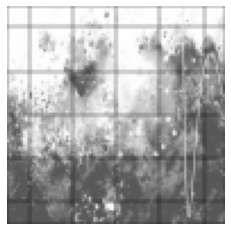

In [15]:
'''Checking Test set'''
#test batch size
test_batch = next(iter(test_set))
imgs, lbls = test_batch
print(imgs.shape, lbls.shape)
#display the first image in test_set
image, label = imgs[0], lbls[0]
print(f"Test Set 0\nImage: {image}\nLabels: {label}\n")
print(image.shape, label.shape)
figure = plt.figure(figsize=(4,4))
figure.add_subplot()
plt.axis("off")
plt.imshow(image.permute(1,2,0), cmap="gray")
plt.show()

In [7]:
'''
    Model built from scratch
'''
# class Network(nn.Module):
#     def __init__(self):
#         super(Network, self).__init__()
#         # more analysis required to determine the specifics of the architecture
       
#         self.n_output = 8
#         self.n_channel = 1
    
#         self.cnn_layers = nn.Sequential(
#                 nn.Conv2d(1, 8, 3), # convolution2dLayer(3,8,'Padding','same')
#                 nn.BatchNorm2d(8),   # batchNormalizationLayer
#                 nn.LeakyReLU(), # reluLayer
#                 nn.MaxPool2d(2, 2), # averagePooling2dLayer(2,'Stride',2)
#                 nn.Conv2d(8, 16, 3), # convolution2dLayer(3,16,'Padding','same')
#                 nn.BatchNorm2d(16), # batchNormalizationLayer
#                 nn.LeakyReLU(), # reluLayer
#                 nn.MaxPool2d(2, 2), # averagePooling2dLayer(2,'Stride',2)
#                 nn.Conv2d(16, 32, 3), # convolution2dLayer(3,32,'Padding','same')
#                 nn.BatchNorm2d(32), # batchNormalizationLayer
#                 nn.LeakyReLU(), # reluLayer
#                 nn.Conv2d(32, 32, 3), # convolution2dLayer(3,32,'Padding','same')
#                 nn.Conv2d(32, 32, 3), # convolution2dLayer(3,32,'Padding','same')
#                 nn.Conv2d(32, 32, 3), # convolution2dLayer(3,32,'Padding','same')
#                 nn.BatchNorm2d(32), # batchNormalizationLayer
#                 nn.LeakyReLU(), # reluLayer
#                 nn.MaxPool2d(2, 2) # Max pooling layer
#         )

#         self.n_input = 1568 # the output of maxpool 96*96 
#         #DONE:actual value might be determined from the computed output of the cnn layers
#         # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

#         self.fc_layers = nn.Sequential(
#         #   fullyConnectedLayer(1)
#             nn.Linear(self.n_input,  4096),
#             nn.LeakyReLU(),
#             nn.Dropout(p=.5),
#             nn.Linear(4096, 4096),
#             nn.LeakyReLU(),
#             nn.Dropout(p=.3),
#             nn.Linear(4096, 128),
#             nn.LeakyReLU(),
#             nn.Dropout(p=.3),
#             nn.Linear(128, 64),
#             nn.LeakyReLU(),
#             nn.Dropout(p=.1),
#             nn.Linear(64, self.n_output),
#             nn.LeakyReLU()
#         )


# #         regressionLayer
#         self.criterion = nn.MSELoss()       
# #    

        
#     def forward(self, x):
#         #feedword pass through our network
#         x = self.cnn_layers(x)
#         x = x.view(x.shape[0], -1) #flatten the input tensor
#         x = self.fc_layers(x)
        
#         return x


#     @staticmethod
#     def load_checkpoint(new_model, filepath):
#         checkpoint = torch.load(filepath)
#         # model = checkpoint['model']
#         new_model.load_state_dict(checkpoint['state_dict'])
#         return new_model
    
#     def save(self, dirpath):
#         self.checkpoint = {
#         #     'input_size': self.n_input, 
#         #     'output_size': self.n_output,
#         #     'cnn_layers': [each. for each in model.cnn_layers],
#         #     'fc_layers': [each.out_features for each in model.fc_layers],
#             'state_dict': model.state_dict()
#         }
#         torch.save(self.checkpoint, f'{dirpath}\\model_checkpoint.pth')

# model = Network() 

In [16]:
# Transfer learning approach
'''Transfer Learning From DenseNet121'''
model = models.densenet121(pretrained=True)
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [17]:
'''
  Substituting the classifier layer
  of densenet121 for our layer
'''
# Freeze parameters so we don't backprop through them
for param in model.parameters():
  param.requires_grad = False

fc_layers = nn.Sequential(
  nn.Linear(1024,  1024),
  nn.LeakyReLU(),
  nn.Dropout(p=.5),
  nn.Linear(1024, 512),
  nn.LeakyReLU(),
  nn.Dropout(p=.3),
  nn.Linear(512, 8),
  nn.LeakyReLU()
)
    
model.classifier = fc_layers

In [18]:
'''
    Creating a measure of accuracy for our network
    based on the RMSE 
'''
# Measure of accuracy
class Measure_Acc(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,predicted, target):
        rmse = torch.sqrt(self.mse(predicted, target))
        rmse_norm = rmse /  20. # normalization 20 = 10 - (-10)
        # print('rmse normal =', rmse_norm)
        accuracy = 100 * (1 - rmse_norm)
        return accuracy

rmse_accuracy = Measure_Acc()

In [19]:
'''
    Defining the validation and train
    functions for training phase
'''

def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels in testloader:
        # if(labels.shape != torch.Size([128, 1, 96, 96])): continue
        # images = images.view(images.shape[0], -1)
        labels = labels.float()
        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)

        # print(f'output={output.shape}')
        # print(f'label={labels.shape}')
        test_loss += criterion(output, labels)
        accuracy += rmse_accuracy(output, labels)

    return test_loss, accuracy



In [20]:
'''
    Defining the validation and train
    functions for training phase
'''
def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every=40):

    steps = 0
    running_loss = 0
    test_losses = []
    train_losses = []
    for e in range(epochs):
        # Model in training mode, dropout is on
        model.train()
        for images, labels in trainloader:
            steps += 1
            # if(labels.shape != torch.Size([128, 1, 96, 96])): continue
            # Flatten images into a 784 long vector
            # images = images.view(images.shape[0], -1)
            labels = labels.float()
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            output = model.forward(images)
            # print(f'output={output.shape}')
            # print(f'label={labels.shape}')
            loss = criterion(output, labels)
            loss.backward() # computes gradient and backpropagation
            optimizer.step() # update of weights and biases happenss
            
            running_loss += loss.item()

            if steps % print_every == 0:
                # Model in inference mode, dropout is off
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion)
                
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))

                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Accuracy: {:.3f}".format(accuracy/len(testloader))
                      )
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()

    # Plotting the losses
    plt.ylim([0, 50])          
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)

In [21]:
'''Execution of the training!!'''

LEARNING_RATE = .001
EPOCHS = 50
LOSS_FN = nn.MSELoss()
OPTIMIZER = optim.Adam(
    model.classifier.parameters(), 
    lr= LEARNING_RATE
)

model.to(device)

train(
    model=model, 
    trainloader=train_set, 
    testloader=test_set, 
    criterion=LOSS_FN,
    optimizer= OPTIMIZER,
    epochs=EPOCHS, 
    print_every=25
)


KeyboardInterrupt: 

Output tensor: [ 1.6742505e-01 -1.8673918e-03 -3.1844620e-04  7.0193559e-02
 -3.0120199e-03 -1.3515922e-04  1.2491967e-01  3.7813061e-01]
Output curve: 


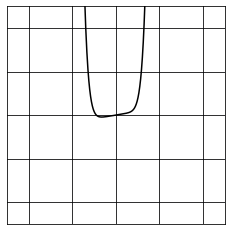

Actual label tensor: [ 5 -9  3  0 -6  5 -7  8]
Actual curve: 


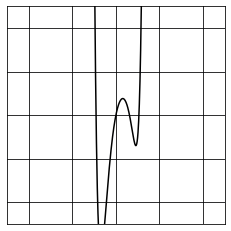

In [22]:
'''Testing the trained network'''
test_batch = next(iter(test_set))
img, lbls = test_batch
img, lbls = img.to(device), lbls.to(device)
# print(img.shape, lbls.shape)

output = model.forward(img)
#print(output)
#print(lbls)

x = np.linspace(-5, 5, 1000)

output0_coeff = output[0]
output0_coeff = output0_coeff.detach().cpu().numpy()
lbls0_coeff = lbls[0]
lbls0_coeff = lbls0_coeff.detach().cpu().numpy()
fig, ax = plt.subplots()

#display output[0] curve
print(f'Output tensor: {output0_coeff}')
print('Output curve: ')
ax.plot(x, 
    (
        (output0_coeff[7]*x**8) + (output0_coeff[6]*x**7) +
        (output0_coeff[5]*x**6) + (output0_coeff[4]*x**5) +
        (output0_coeff[3]*x**4) + (output0_coeff[2]*x**3) + 
        (output0_coeff[1]*x**2) + (output0_coeff[0]*x**1)
    ),color='#000000')
    
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(
    left = False, 
    labelleft = False,
    bottom =  False, 
    labelbottom = False
)
ax.grid(color='#000001')

plt.show()

#display actual curve
print(f'Actual label tensor: {lbls0_coeff}')
print('Actual curve: ')
fig, ax = plt.subplots()

ax.plot( x, 
    (
        (lbls0_coeff[7]*x**8) + (lbls0_coeff[6]*x**7) +
        (lbls0_coeff[5]*x**6) + (lbls0_coeff[4]*x**5) + 
        (lbls0_coeff[3]*x**4) + (lbls0_coeff[2]*x**3) + 
        (lbls0_coeff[1]*x**2) + (lbls0_coeff[0]*x**1)
    ), color='#000000')
    
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(
    left = False, 
    labelleft = False,
    bottom =  False, 
    labelbottom = False
)
ax.grid(color='#000001')

plt.show()

In [25]:
'''Saving the trained model'''
def save_checkpoint(path):
    checkpoint = {
        'model': model.to(torch.device('cpu')),
        'features': model.features,
        'estimator': model.classifier,
        'state_dict': model.state_dict(),
    }
    torch.save(checkpoint, path)

save_checkpoint('../models/model_checkpoint.pth')

In [26]:
'''Loading the save model at the specified path'''
def load_checkpoint(path):
    '''give absolute path'''
    checkpoint = torch.load(path)
    model = checkpoint['model']
    model.classifier = checkpoint['estimator']
    model.load_state_dict(checkpoint['state_dict'])
    return checkpoint, model

checkpoint, model = load_checkpoint('../models/model_checkpoint.pth')
print(checkpoint, model)

FileNotFoundError: [Errno 2] No such file or directory: 'models/model_checkpoint.pth'

Output tensor: [ 5.6838956  -8.467546   -6.5452247   0.66510093 -5.0171356   4.685207
 -3.2718596  -3.1595328 ]
Output curve: 


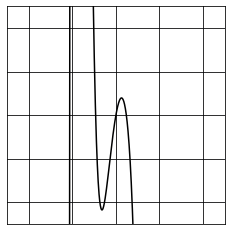

Actual label tensor: [  5 -10  -4   3  -7   7  -9  -7]
Actual curve: 


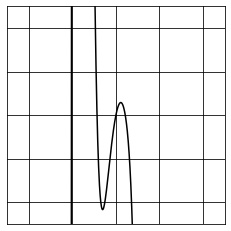

In [ ]:
'''Testing the trained network'''
test_batch = next(iter(test_set))
img, lbls = test_batch
img, lbls = img.to(device), lbls.to(device)
# print(img.shape, lbls.shape)

output = model.forward(img)
#print(output)
#print(lbls)

x = np.linspace(-5, 5, 1000)

output0_coeff = output[0]
output0_coeff = output0_coeff.detach().cpu().numpy()
lbls0_coeff = lbls[0]
lbls0_coeff = lbls0_coeff.detach().cpu().numpy()
fig, ax = plt.subplots()

#display output[0] curve
print(f'Output tensor: {output0_coeff}')
print('Output curve: ')
ax.plot(x, 
    (
        (output0_coeff[7]*x**8) + (output0_coeff[6]*x**7) +
        (output0_coeff[5]*x**6) + (output0_coeff[4]*x**5) +
        (output0_coeff[3]*x**4) + (output0_coeff[2]*x**3) + 
        (output0_coeff[1]*x**2) + (output0_coeff[0]*x**1)
    ),color='#000000')
    
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(
    left = False, 
    labelleft = False,
    bottom =  False, 
    labelbottom = False
)
ax.grid(color='#000001')

plt.show()

#display actual curve
print(f'Actual label tensor: {lbls0_coeff}')
print('Actual curve: ')
fig, ax = plt.subplots()

ax.plot( x, 
    (
        (lbls0_coeff[7]*x**8) + (lbls0_coeff[6]*x**7) +
        (lbls0_coeff[5]*x**6) + (lbls0_coeff[4]*x**5) + 
        (lbls0_coeff[3]*x**4) + (lbls0_coeff[2]*x**3) + 
        (lbls0_coeff[1]*x**2) + (lbls0_coeff[0]*x**1)
    ), color='#000000')
    
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(
    left = False, 
    labelleft = False,
    bottom =  False, 
    labelbottom = False
)
ax.grid(color='#000001')

plt.show()